In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

C:\Users\KIIT\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = MNIST(root='data/', download=True)

In [3]:
len(dataset)

60000

In [4]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28>, 5)

3


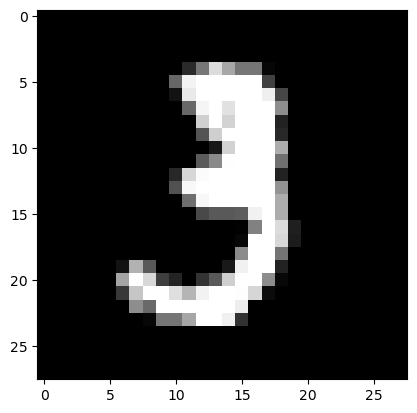

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
image,label=dataset[10]
print(label)
plt.imshow(image,cmap='gray');

In [7]:
import torchvision.transforms as transforms


In [8]:
dataset=MNIST(root='data/', 
                train=True,
                transform=transforms.ToTensor())

In [9]:
img_tensor,label=dataset[0]
print(img_tensor.shape,label)

torch.Size([1, 28, 28]) 5


The image is now converted to a 1x28x28 tensor. The first dimension tracks color channels. The second and third dimensions represent pixels along the height and width of the image, respectively. Since images in the MNIST dataset are grayscale, there's just one channel. Other datasets have images with color, in which case there are three channels: red, green, and blue (RGB).

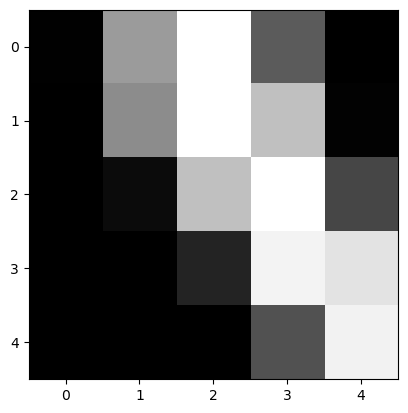

In [10]:
plt.imshow(img_tensor[0,10:15,10:15],cmap='gray');

In [11]:
print(img_tensor[0,10:15,10:15])

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])


In [12]:
from torch.utils.data import random_split
train_ds,val_ds=random_split(dataset,[50000,10000])
len(train_ds),len(val_ds)

(50000, 10000)

In [49]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

<generator object <genexpr> at 0x000001FE7F0F13C0>


## Model

Now that we have prepared our data loaders, we can define our model.

* A **logistic regression** model is almost identical to a linear regression model. It contains weights and bias matrices, and the output is obtained using simple matrix operations (`pred = x @ w.t() + b`). 

* As we did with linear regression, we can use `nn.Linear` to create the model instead of manually creating and initializing the matrices.

* Since `nn.Linear` expects each training example to be a vector, each `1x28x28` image tensor is _flattened_ into a vector of size 784 `(28*28)` before being passed into the model. 

* The output for each image is a vector of size 10, with each element signifying the probability of a particular target label (i.e., 0 to 9). The predicted label for an image is simply the one with the highest probability.

In [14]:
import torch.nn as nn

input_size=28*28
num_classes=10

model=nn.Linear(input_size,num_classes)

In [15]:
model.weight.shape

torch.Size([10, 784])

In [16]:
model.bias

Parameter containing:
tensor([-0.0342, -0.0133, -0.0267,  0.0101, -0.0202, -0.0275,  0.0031, -0.0209,
        -0.0145, -0.0050], requires_grad=True)

In [19]:
for images,labels in train_loader:
    print(labels)
    print(images.shape)
    outputs=model(images)

tensor([4, 4, 0, 5, 8, 9, 3, 0, 4, 0, 6, 9, 0, 2, 3, 7, 2, 5, 8, 3, 7, 4, 6, 8,
        7, 1, 7, 2, 9, 1, 3, 3, 3, 0, 0, 2, 7, 9, 0, 8, 9, 3, 7, 6, 4, 4, 8, 4,
        6, 1, 9, 3, 9, 0, 6, 5, 2, 9, 3, 2, 6, 6, 5, 7, 0, 9, 3, 7, 7, 1, 5, 8,
        3, 3, 3, 4, 3, 3, 5, 4, 4, 9, 7, 6, 1, 0, 1, 8, 5, 5, 1, 0, 5, 7, 3, 4,
        6, 3, 7, 9, 1, 5, 7, 4, 9, 2, 6, 9, 7, 2, 2, 3, 8, 8, 9, 0, 8, 7, 4, 6,
        9, 9, 2, 1, 4, 2, 6, 7])
torch.Size([128, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x10)

The code above leads to an error because our input data does not have the right shape. Our images are of the shape 1x28x28, but we need them to be vectors of size 784, i.e., we need to flatten them. We'll use the `.reshape` method of a tensor, which will allow us to efficiently 'view' each image as a flat vector without really creating a copy of the underlying data. To include this additional functionality within our model, we need to define a custom model by extending the `nn.Module` class from PyTorch. 

A class in Python provides a "blueprint" for creating objects. Let's look at an example of defining a new class in Python.

In [20]:
images.reshape(128,784).shape

torch.Size([128, 784])

In [21]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear=nn.Linear(input_size,num_classes)
    
    def forward(self,xb):
        xb=xb.reshape(-1,784)
        out=self.linear(xb)
        return out
    
model=MnistModel()

Inside the `__init__` constructor method, we instantiate the weights and biases using `nn.Linear`. And inside the `forward` method, which is invoked when we pass a batch of inputs to the model, we flatten the input tensor and pass it into `self.linear`.

`xb.reshape(-1, 28*28)` indicates to PyTorch that we want a *view* of the `xb` tensor with two dimensions. The length along the 2nd dimension is 28\*28 (i.e., 784). One argument to `.reshape` can be set to `-1` (in this case, the first dimension) to let PyTorch figure it out automatically based on the shape of the original tensor.

Note that the model no longer has `.weight` and `.bias` attributes (as they are now inside the `.linear` attribute), but it does have a `.parameters` method that returns a list containing the weights and bias.

In [22]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [23]:
print(model.linear.weight.shape,model.linear.bias.shape)

torch.Size([10, 784]) torch.Size([10])


In [24]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0305,  0.0325, -0.0118,  ...,  0.0033, -0.0356, -0.0089],
         [ 0.0120,  0.0279,  0.0349,  ..., -0.0202, -0.0045,  0.0029],
         [-0.0314, -0.0104,  0.0233,  ..., -0.0227,  0.0026, -0.0112],
         ...,
         [ 0.0321, -0.0237, -0.0280,  ...,  0.0223,  0.0105,  0.0010],
         [ 0.0180, -0.0315,  0.0225,  ...,  0.0354, -0.0027, -0.0231],
         [-0.0320,  0.0211, -0.0263,  ...,  0.0020, -0.0269, -0.0346]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0352,  0.0237, -0.0126, -0.0213,  0.0246,  0.0131, -0.0029, -0.0049,
          0.0042, -0.0094], requires_grad=True)]

In [25]:
for images,labels in train_loader:
    print(images.shape)
    outputs=model(images)
    break;
print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:10].data)

torch.Size([128, 1, 28, 28])
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[-0.0930,  0.1517, -0.0530, -0.1134,  0.3308, -0.1285,  0.0742, -0.1281,
          0.0374, -0.0397],
        [-0.0295,  0.0883, -0.0844,  0.0398,  0.0179, -0.2995, -0.2987, -0.2260,
         -0.0320,  0.0108],
        [-0.0435,  0.0263, -0.2465,  0.1077, -0.0442, -0.1243, -0.0392, -0.2418,
         -0.2017, -0.2161],
        [ 0.0171, -0.0575, -0.1012,  0.2046, -0.2554, -0.0562, -0.1622,  0.0464,
          0.2231,  0.0262],
        [-0.2448, -0.3311, -0.0051,  0.1637, -0.1751,  0.0588, -0.0829,  0.0630,
          0.1046, -0.2032],
        [-0.1364, -0.3668, -0.0786, -0.2868,  0.1506, -0.1399,  0.2499, -0.5111,
         -0.0123,  0.0045],
        [-0.0598,  0.2362, -0.0684, -0.1007,  0.1623, -0.1160, -0.0565, -0.2971,
          0.0057,  0.0207],
        [-0.0148, -0.0104,  0.0150,  0.0511, -0.0775, -0.1076,  0.1047, -0.2389,
         -0.0073, -0.0869],
        [-0.4608,  0.0131, -0.1447, -0.150

For each of the 100 input images, we get 10 outputs, one for each class. As discussed earlier, we'd like these outputs to represent probabilities. Each output row's elements must lie between 0 to 1 and add up to 1, which is not the case. 

To convert the output rows into probabilities, we use the softmax function, which has the following formula:


In [26]:
import torch.nn.functional as F

The `softmax function` is included in the torch.nn.functional package and requires us to specify a dimension along which the function should be applied.

In [27]:
probs=F.softmax(outputs,dim=1)

print("Sample probabilities:\n",probs[:10].data)
print("Sum: ", torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.0898, 0.1147, 0.0935, 0.0880, 0.1372, 0.0867, 0.1062, 0.0867, 0.1023,
         0.0947],
        [0.1044, 0.1174, 0.0988, 0.1119, 0.1095, 0.0797, 0.0798, 0.0858, 0.1041,
         0.1087],
        [0.1053, 0.1130, 0.0860, 0.1225, 0.1053, 0.0972, 0.1058, 0.0864, 0.0899,
         0.0886],
        [0.1019, 0.0945, 0.0905, 0.1229, 0.0776, 0.0947, 0.0851, 0.1049, 0.1252,
         0.1028],
        [0.0825, 0.0757, 0.1049, 0.1242, 0.0885, 0.1118, 0.0970, 0.1123, 0.1170,
         0.0860],
        [0.0954, 0.0757, 0.1011, 0.0820, 0.1271, 0.0950, 0.1403, 0.0656, 0.1080,
         0.1098],
        [0.0958, 0.1289, 0.0950, 0.0920, 0.1197, 0.0906, 0.0962, 0.0756, 0.1023,
         0.1039],
        [0.1019, 0.1023, 0.1049, 0.1088, 0.0957, 0.0928, 0.1148, 0.0814, 0.1026,
         0.0948],
        [0.0685, 0.1100, 0.0939, 0.0933, 0.0941, 0.0836, 0.0996, 0.1364, 0.0884,
         0.1322],
        [0.0774, 0.0985, 0.0882, 0.0931, 0.1060, 0.1001, 0.0945, 0.1061, 0.1172,
     

In [28]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(labels)

tensor([4, 1, 3, 8, 3, 6, 1, 6, 7, 9, 8, 4, 5, 9, 6, 8, 3, 8, 6, 2, 3, 3, 3, 8,
        8, 8, 1, 8, 4, 5, 5, 4, 8, 2, 3, 4, 4, 6, 8, 9, 3, 8, 8, 8, 4, 1, 4, 4,
        2, 3, 0, 4, 3, 4, 9, 0, 6, 0, 1, 8, 3, 8, 4, 5, 0, 8, 6, 9, 0, 1, 3, 8,
        8, 4, 8, 4, 0, 0, 5, 5, 4, 8, 6, 8, 3, 0, 8, 3, 9, 3, 8, 9, 9, 9, 5, 3,
        9, 5, 3, 7, 4, 4, 5, 4, 5, 8, 3, 4, 4, 4, 5, 8, 4, 5, 1, 6, 5, 5, 6, 4,
        3, 8, 8, 4, 3, 3, 5, 8])
tensor([7, 2, 8, 7, 9, 0, 0, 7, 4, 4, 6, 8, 8, 9, 9, 2, 5, 6, 5, 5, 7, 7, 1, 0,
        9, 9, 9, 0, 0, 8, 1, 5, 7, 3, 4, 5, 5, 2, 6, 2, 1, 8, 2, 9, 0, 4, 0, 9,
        9, 4, 1, 3, 3, 0, 9, 1, 0, 1, 2, 7, 1, 4, 5, 8, 1, 7, 7, 2, 2, 2, 5, 6,
        6, 3, 6, 3, 1, 2, 1, 5, 0, 3, 0, 8, 2, 1, 7, 3, 4, 2, 1, 5, 0, 5, 3, 7,
        1, 1, 4, 7, 8, 8, 5, 5, 3, 4, 9, 5, 5, 0, 0, 6, 3, 0, 1, 0, 0, 1, 7, 0,
        2, 7, 8, 5, 2, 4, 7, 2])


Most of the predicted labels are different from the actual labels. That's because we have started with randomly initialized weights and biases. We need to train the model, i.e., adjust the weights using gradient descent to make better predictions.

# Evaluation Metric and Loss Function

Just as with linear regression, we need a way to evaluate how well our model is performing. A natural way to do this would be to find the percentage of labels that were predicted correctly, i.e,. the **accuracy** of the predictions.

Accuracy is an excellent way for us (humans) to evaluate the model. However, we can't use it as a loss function for optimizing our model using gradient descent for the following reasons:

1. It's not a differentiable function. `torch.max` and `==` are both non-continuous and non-differentiable operations, so we can't use the accuracy for computing gradients w.r.t the weights and biases.

2. It doesn't take into account the actual probabilities predicted by the model, so it can't provide sufficient feedback for incremental improvements. 

For these reasons, accuracy is often used as an **evaluation metric** for classification, but not as a loss function. A commonly used loss function for classification problems is the **cross-entropy**, which has the following formula:

![cross-entropy](https://i.imgur.com/VDRDl1D.png)

While it looks complicated, it's actually quite simple:

* For each output row, pick the predicted probability for the correct label. E.g., if the predicted probabilities for an image are `[0.1, 0.3, 0.2, ...]` and the correct label is `1`, we pick the corresponding element `0.3` and ignore the rest.

* Then, take the [logarithm](https://en.wikipedia.org/wiki/Logarithm) of the picked probability. If the probability is high, i.e., close to 1, then its logarithm is a very small negative value, close to 0. And if the probability is low (close to 0), then the logarithm is a very large negative value. We also multiply the result by -1, which results is a large postive value of the loss for poor predictions.

![](https://www.intmath.com/blog/wp-content/images/2019/05/log10.png)

* Finally, take the average of the cross entropy across all the output rows to get the overall loss for a batch of data.

Unlike accuracy, cross-entropy is a continuous and differentiable function. It also provides useful feedback for incremental improvements in the model (a slightly higher probability for the correct label leads to a lower loss). These two factors make cross-entropy a better choice for the loss function.

As you might expect, PyTorch provides an efficient and tensor-friendly implementation of cross-entropy as part of the `torch.nn.functional` package. Moreover, it also performs softmax internally, so we can directly pass in the model's outputs without converting them into probabilities.

In [29]:
loss_fn=F.cross_entropy

In [30]:
loss=loss_fn(outputs,labels)
print(loss)

tensor(2.2989, grad_fn=<NllLossBackward0>)


## Training the model

Now that we have defined the data loaders, model, loss function and optimizer, we are ready to train the model. The training process is identical to linear regression, with the addition of a "validation phase" to evaluate the model in each epoch. Here's what it looks like in pseudocode:

```
for epoch in range(num_epochs):
    # Training phase
    for batch in train_loader:
        # Generate predictions
        # Calculate loss
        # Compute gradients
        # Update weights
        # Reset gradients
    
    # Validation phase
    for batch in val_loader:
        # Generate predictions
        # Calculate loss
        # Calculate metrics (accuracy etc.)
    # Calculate average validation loss & metrics
    
    # Log epoch, loss & metrics for inspection
```

Some parts of the training loop are specific the specific problem we're solving (e.g. loss function, metrics etc.) whereas others are generic and can be applied to any deep learning problem. 

We'll include the problem-independent parts within a function called `fit`, which will be used to train the model. The problem-specific parts will be implemented by adding new methods to the `nn.Module` class.


# Model

In [53]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

# Training

In [59]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [60]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [62]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [63]:
result0=evaluate(model,val_loader)
result0

{'val_loss': 2.2871291637420654, 'val_acc': 0.13617484271526337}

In [64]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9220, val_acc: 0.6596
Epoch [1], val_loss: 1.6571, val_acc: 0.7399
Epoch [2], val_loss: 1.4601, val_acc: 0.7708
Epoch [3], val_loss: 1.3116, val_acc: 0.7890
Epoch [4], val_loss: 1.1973, val_acc: 0.8033


In [65]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1075, val_acc: 0.8132
Epoch [1], val_loss: 1.0352, val_acc: 0.8207
Epoch [2], val_loss: 0.9761, val_acc: 0.8265
Epoch [3], val_loss: 0.9267, val_acc: 0.8305
Epoch [4], val_loss: 0.8849, val_acc: 0.8344


In [66]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8491, val_acc: 0.8380
Epoch [1], val_loss: 0.8180, val_acc: 0.8406
Epoch [2], val_loss: 0.7908, val_acc: 0.8422
Epoch [3], val_loss: 0.7666, val_acc: 0.8455
Epoch [4], val_loss: 0.7452, val_acc: 0.8473


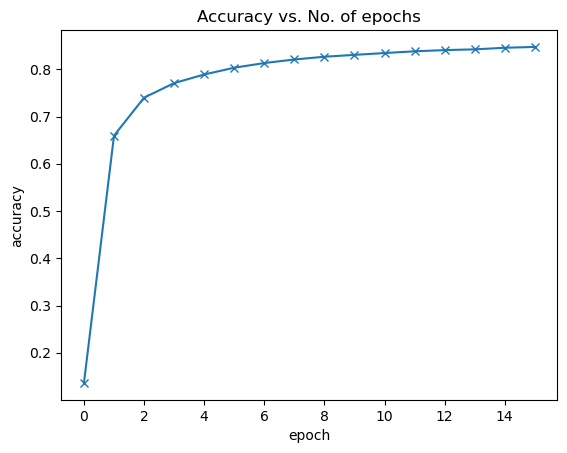

In [67]:
history = [result0] + history1 + history2 + history3
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');